<a href="https://colab.research.google.com/github/kosmasrio0411/Final-Project-PCD/blob/main/Final_Project_PCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================
# 1. Install dan import library
# ============================================================
import os
from pathlib import Path
import numpy as np
import cv2
import kagglehub
from tqdm import tqdm

import matplotlib.pyplot as plt

from skimage.segmentation import active_contour
from skimage.filters import gaussian
from skimage.draw import polygon
from skimage.feature import graycomatrix, graycoprops
from scipy import ndimage as ndi

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Untuk menghindari warning yang mengganggu
import warnings
warnings.filterwarnings("ignore")


In [2]:
# ============================================================
# 2. Download dataset TBX-11 dari Kaggle dengan kagglehub
# ============================================================

dataset_path = kagglehub.dataset_download("usmanshams/tbx-11")
print("Dataset path:", dataset_path)

# Lihat isi folder paling atas
print("Top-level files/folders:", os.listdir(dataset_path))


100%|██████████| 3.08G/3.08G [00:29<00:00, 111MB/s]

Extracting files...


Dataset path: /root/.cache/kagglehub/datasets/usmanshams/tbx-11/versions/1
Top-level files/folders: ['TBX11K']


In [3]:
# ============================================================
# 3. Utilitas: cari semua path image dan buat label TB vs Non-TB
# ============================================================
# Di TBX11K biasanya kelasnya: Healthy, Sick but non-TB, Active TB, Latent TB, Uncertain TB.
# Kita ubah menjadi biner:
#    TB     : Active TB, Latent TB, Active&Latent TB
#    Non-TB : Healthy, Sick but non-TB
# Uncertain TB bisa di-skip.

IMAGE_EXTS = (".png", ".jpg", ".jpeg")

def list_all_images(root_dir):
    root = Path(root_dir)
    paths = []
    for p in root.rglob("*"):
        if p.suffix.lower() in IMAGE_EXTS:
            paths.append(str(p))
    return paths

def map_path_to_binary_label(path_str):
    """
    Mengembalikan:
      1 = TB
      0 = Non-TB
      None = tidak dipakai (misal Uncertain TB)
    Mapping dilakukan berdasarkan nama folder yang muncul di path.
    Sesuaikan jika nama folder di dataset kamu berbeda.
    """
    parts = [part.lower() for part in Path(path_str).parts]

    category = None

    for p in parts:
        if "uncertain" in p:
            category = "uncertain"
            break
        if "healthy" in p or "normal" in p:
            category = "healthy"
            break
        if "sick" in p and "tb" not in p:
            category = "sick_non_tb"
            break
        if "non-tb" in p or "nontb" in p:
            category = "sick_non_tb"
            break
        if "active" in p and "tb" in p:
            category = "active_tb"
            break
        if "latent" in p and "tb" in p:
            category = "latent_tb"
            break
        # fallback sangat kasar: kalau nama foldernya persis "tb"
        if p == "tb":
            category = "tb"
            break

    if category in ["active_tb", "latent_tb", "tb"]:
        return 1      # TB
    elif category in ["healthy", "sick_non_tb"]:
        return 0      # Non-TB
    else:
        return None   # tidak dipakai

all_image_paths = list_all_images(dataset_path)
print("Total image files ditemukan:", len(all_image_paths))

# Ubah ke list berisi (path, label_biner)
labeled_paths = []
for p in all_image_paths:
    label = map_path_to_binary_label(p)
    if label is not None:
        labeled_paths.append((p, label))

print("Total image yang dipakai setelah mapping TB vs Non-TB:", len(labeled_paths))

# Opsional: batasi jumlah per kelas supaya training cepat
MAX_PER_CLASS = 1200  # silakan naikkan kalau komputernya kuat

tb_paths = [p for p, y in labeled_paths if y == 1][:MAX_PER_CLASS]
nontb_paths = [p for p, y in labeled_paths if y == 0][:MAX_PER_CLASS]

paths_balanced = tb_paths + nontb_paths
labels_balanced = [1]*len(tb_paths) + [0]*len(nontb_paths)

print("Jumlah TB:", len(tb_paths))
print("Jumlah Non-TB:", len(nontb_paths))


Total image files ditemukan: 12279
Total image yang dipakai setelah mapping TB vs Non-TB: 4600
Jumlah TB: 800
Jumlah Non-TB: 1200


In [4]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def preprocess_image(img):
    # Baca grayscale

    # Resize
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)

    # CLAHE (adaptHistEq versi OpenCV)
    img = clahe.apply(img)

    # Gaussian filter
    img = cv2.GaussianBlur(img, (5, 5), 0)

    return img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

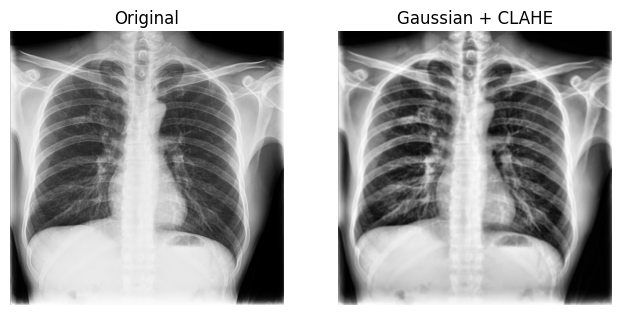

In [5]:
sample_img = cv2.imread(paths_balanced[0], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)


plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Gaussian + CLAHE"); plt.axis("off")



In [6]:
import cv2
import numpy as np
from scipy import ndimage as ndi

def get_body_mask(img):
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)

    h, w = img.shape

    border = int(0.02 * min(h, w))
    work = img.copy()
    work[:border, :] = 0
    work[-border:, :] = 0
    work[:, :border] = 0
    work[:, -border:] = 0

    blur = cv2.GaussianBlur(work, (5, 5), 0)
    _, body_bin = cv2.threshold(
        blur, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    body_bin = cv2.morphologyEx(body_bin, cv2.MORPH_CLOSE, k, iterations=3)

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(body_bin)

    if num_labels <= 1:
        body_mask = np.zeros_like(img, np.uint8)
        cv2.ellipse(
            body_mask,
            center=(w // 2, int(h * 0.52)),
            axes=(int(w * 0.45), int(h * 0.48)),
            angle=0, startAngle=0, endAngle=360,
            color=1, thickness=-1
        )
        return body_mask

    areas = stats[1:, cv2.CC_STAT_AREA]
    main = 1 + np.argmax(areas)
    body_mask = (labels == main).astype(np.uint8)
    body_mask = ndi.binary_fill_holes(body_mask.astype(bool)).astype(np.uint8)

    return body_mask


def ellipse_from_body(body_mask):
    h, w = body_mask.shape
    ys, xs = np.where(body_mask > 0)

    if len(xs) == 0:
        cx, cy = w // 2, int(h * 0.52)
        rx, ry = int(w * 0.35), int(h * 0.4)
    else:
        x_min, x_max = xs.min(), xs.max()
        y_min, y_max = ys.min(), ys.max()
        w_box = x_max - x_min
        h_box = y_max - y_min
        cx = (x_min + x_max) // 2
        cy = (y_min + y_max) // 2
        rx = int(w_box * 0.4)
        ry = int(h_box * 0.45)

    mask = np.zeros_like(body_mask, np.uint8)
    cv2.ellipse(
        mask,
        center=(cx, cy),
        axes=(rx, ry),
        angle=0, startAngle=0, endAngle=360,
        color=1, thickness=-1
    )
    return mask

def smooth_lung_contour_circle(lung_mask, radius=15):
    """
    Smooth contour paru:
    - proses per connected component (paru kiri & kanan)
    - closing besar + opening sedikit lebih kecil dengan kernel lingkaran
    - cleanup: hanya ambil blob terbesar per paru supaya tonjolan kecil hilang
    radius: kira-kira ukuran gerigi (rib) yang mau dihalusin
    """
    lung_mask_u8 = (lung_mask > 0).astype(np.uint8)

    # pastikan radius masuk akal
    radius = max(int(radius), 1)
    r_close = radius
    r_open  = max(radius // 2, 1)   # opening lebih kecil dari closing

    # kernel lingkaran (ellipse dengan w = h)
    k_close = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (2 * r_close + 1, 2 * r_close + 1)
    )
    k_open = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (2 * r_open + 1, 2 * r_open + 1)
    )

    num_labels, labels = cv2.connectedComponents(lung_mask_u8)
    out = np.zeros_like(lung_mask_u8)

    for lab in range(1, num_labels):  # skip background
        comp = (labels == lab).astype(np.uint8)

        # 1) closing besar: nutup lembah-lembah di antara tulang
        comp = cv2.morphologyEx(comp, cv2.MORPH_CLOSE, k_close, iterations=1)

        # 2) opening kecil: buang tonjolan kecil di luar paru
        comp = cv2.morphologyEx(comp, cv2.MORPH_OPEN, k_open, iterations=1)

        # 3) cleanup: kalau masih kebentuk beberapa blob, ambil yang terbesar saja
        num2, labels2 = cv2.connectedComponents(comp)
        if num2 > 1:
            areas = []
            for i in range(1, num2):
                areas.append(np.count_nonzero(labels2 == i))
            if areas:
                keep = np.argmax(areas) + 1
                comp = (labels2 == keep).astype(np.uint8)

        out[comp > 0] = 1

    return out.astype(np.uint8)
def refine_body_region(body_mask, h, w):
    """
    Persempit body_mask ke area thorax tengah:
    - buang bahu (atas)
    - buang sisi kiri/kanan ekstrim (area dekat lengan)
    - opsional: buang bagian paling bawah (abdomen)
    """
    mask = body_mask.copy().astype(np.uint8)

    # buang 8% paling atas (leher, kepala)
    top_cut = int(0.1 * h)
    mask[:top_cut, :] = 0

    # buang 5% paling bawah (abdomen, perut) – opsional
    bottom_cut = int(0.95 * h)
    mask[bottom_cut:, :] = 0

    # buang 15% kiri & kanan (area dekat lengan & scapula)
    x_margin = int(0.1 * w)
    mask[:, :x_margin] = 0
    mask[:, w - x_margin:] = 0

    return mask

def limit_to_thorax(mask, h, w):
    """
    Memotong mask ke area thorax tengah:
    - buang bagian atas (leher / tulang bahu yang tinggi)
    - buang sisi kiri/kanan yang terlalu dekat lengan
    - (opsional) buang sedikit bagian paling bawah
    """
    m = mask.copy().astype(np.uint8)

    # buang % bagian atas (clavicle, leher, sebagian bahu)
    top_cut = int(0.08 * h)  # bisa kamu turunkan/naikkan 0.15–0.2
    m[:top_cut, :] = 0

    # buang 8% kiri & kanan (area dekat lengan)
    x_margin = int(0.08 * w)
    m[:, :x_margin] = 0
    m[:, w - x_margin:] = 0

    # opsional: buang 5% terbawah (abdomen)
    bottom_cut = int(0.95 * h)
    m[bottom_cut:, :] = 0

    return m
def segment_lungs_final(img_pre, debug=False):
    """
    Segmentasi paru:
    - body mask
    - Otsu invert di dalam body
    - morph + CC
    - post-processing: smoothing + filter 2 komponen paru
    """
    if img_pre.dtype != np.uint8:
        img = np.clip(img_pre, 0, 255).astype(np.uint8)
    else:
        img = img_pre.copy()

    h, w = img.shape

    # 1) Body (torso) mask
    body_mask = get_body_mask(img)
    body_mask = refine_body_region(body_mask, h, w)   # <-- hanya pakai ini
    body_area = body_mask.sum()
    if debug:
        print("body area ratio:", body_area / (h * w + 1e-8))

    # 2) Threshold hanya di area body
    img_body = img.copy()
    img_body[body_mask == 0] = 0

    blur = cv2.GaussianBlur(img_body, (5, 5), 0)
    torso_pixels = blur[body_mask == 1].reshape(-1, 1)

    # Otsu di dalam torso
    ret, _ = cv2.threshold(
        torso_pixels, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    thresh_val = ret

    # lungs lebih gelap ⇒ invert
    _, lung_bin = cv2.threshold(
        blur, thresh_val, 255,
        cv2.THRESH_BINARY_INV
    )
    lung_bin[body_mask == 0] = 0

    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    lung_bin = cv2.morphologyEx(lung_bin, cv2.MORPH_OPEN, k, iterations=1)
    lung_bin = cv2.morphologyEx(lung_bin, cv2.MORPH_CLOSE, k, iterations=3)

    lung_mask = ndi.binary_fill_holes(lung_bin > 0).astype(np.uint8)
    lung_mask_255 = (lung_mask * 255).astype(np.uint8)

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(lung_mask_255)
    if debug:
        print("num_labels (lung):", num_labels)

    # 2b) Pilih kandidat paru berdasarkan area & posisi
    candidates = []
    for lab in range(1, num_labels):
        area = stats[lab, cv2.CC_STAT_AREA]
        if area < 0.02 * body_area or area > 0.7 * body_area:
            continue
        cx, cy = centroids[lab]
        if not (0.1 * w < cx < 0.9 * w and 0.15 * h < cy < 0.95 * h):
            continue
        candidates.append((area, lab))

    if len(candidates) >= 1:
        candidates.sort(reverse=True, key=lambda x: x[0])
        chosen = [lab for _, lab in candidates[:2]]
        lung_mask = np.isin(labels, chosen).astype(np.uint8)
    else:
        if debug:
            print("tidak ada kandidat yang wajar → fallback ellipse")
        lung_mask = ellipse_from_body(body_mask)

    # 3) Post-processing bentuk paru

    # hanya di dalam body
    lung_mask = (lung_mask.astype(np.uint8) & body_mask.astype(np.uint8))

    # smoothing contour dengan kernel lingkaran per paru
    lung_mask = smooth_lung_contour_circle(lung_mask, radius=15)

    # isi lagi semua lubang di dalam paru
    lung_mask = ndi.binary_fill_holes(lung_mask > 0).astype(np.uint8)

    # FINAL: ambil hanya 2 komponen terbesar yang posisinya wajar
    num_l, labels_l, stats_l, cents_l = cv2.connectedComponentsWithStats(
        lung_mask.astype(np.uint8)
    )

    if num_l > 1:
        areas = stats_l[1:, cv2.CC_STAT_AREA]          # skip background (0)
        order = np.argsort(areas)[::-1]                # besar → kecil
        top2 = order[:2] + 1

        valid_labels = []
        for lab in top2:
            cx, cy = cents_l[lab]
            # centroid harus berada di tengah thorax (bukan terlalu atas)
            if 0.1 * w < cx < 0.9 * w and 0.20 * h < cy < 0.95 * h:
                valid_labels.append(lab)

        if len(valid_labels) == 0:
            valid_labels = list(top2)  # fallback

        lung_mask = np.isin(labels_l, valid_labels).astype(np.uint8)

    lung_area_ratio = lung_mask.sum() / (h * w + 1e-8)
    if debug:
        print("lung area ratio:", lung_area_ratio)

    segmented = img * lung_mask
    return segmented, lung_mask


mask sum: 82722


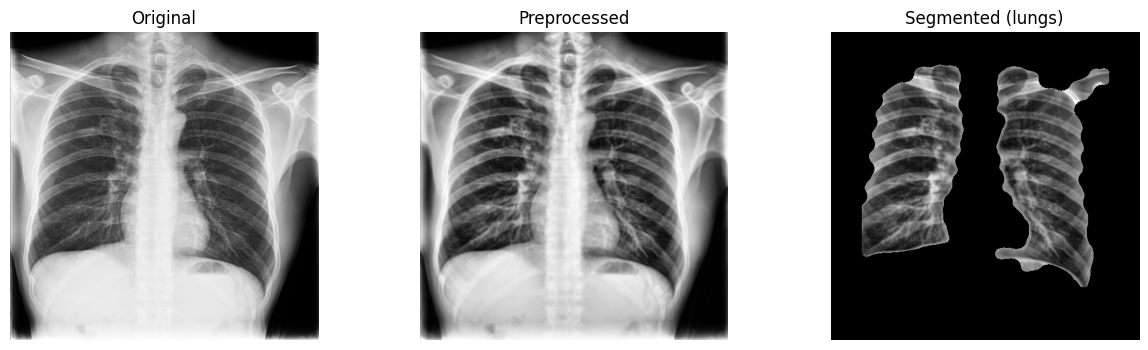

mask sum: 56535


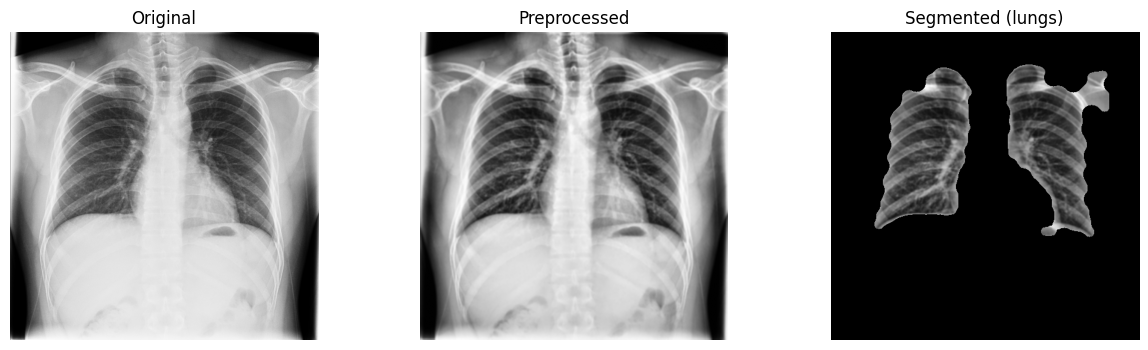

mask sum: 72943


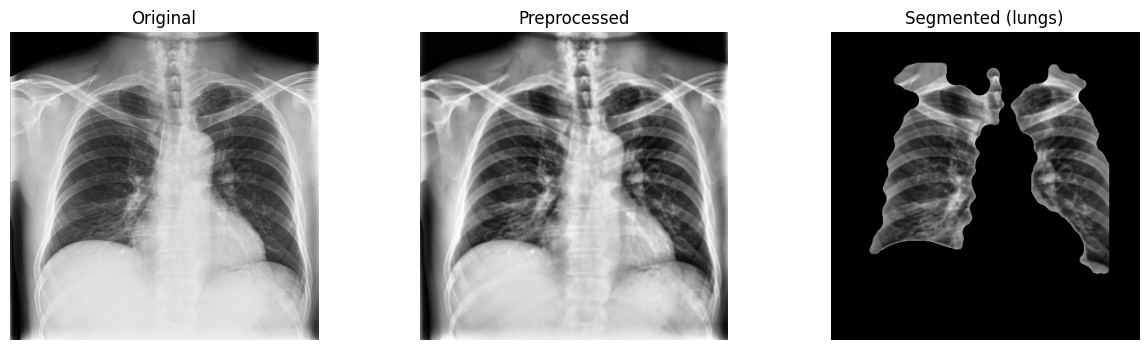

mask sum: 42779


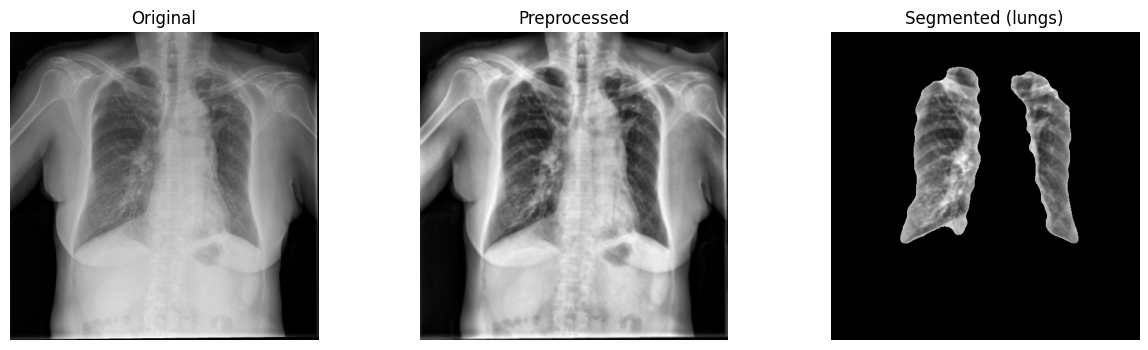

mask sum: 95480


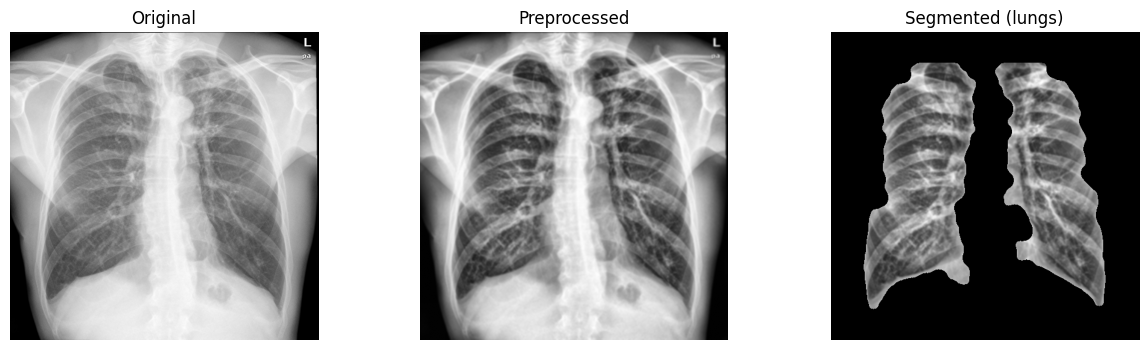

mask sum: 58761


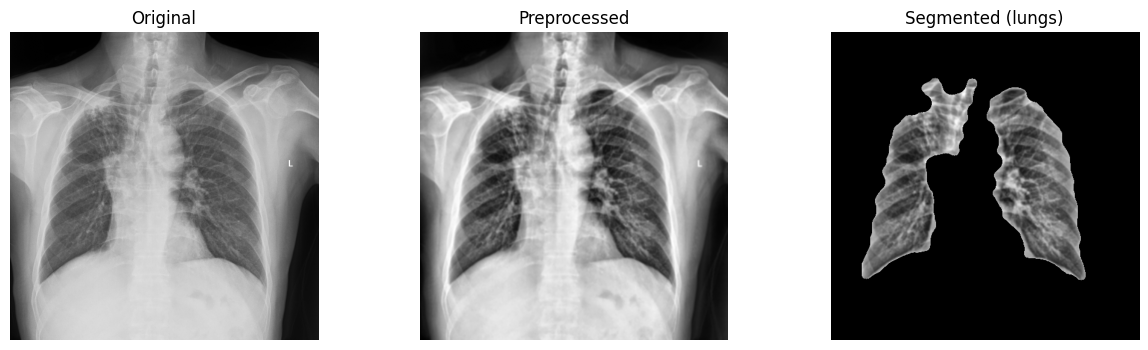

mask sum: 68304


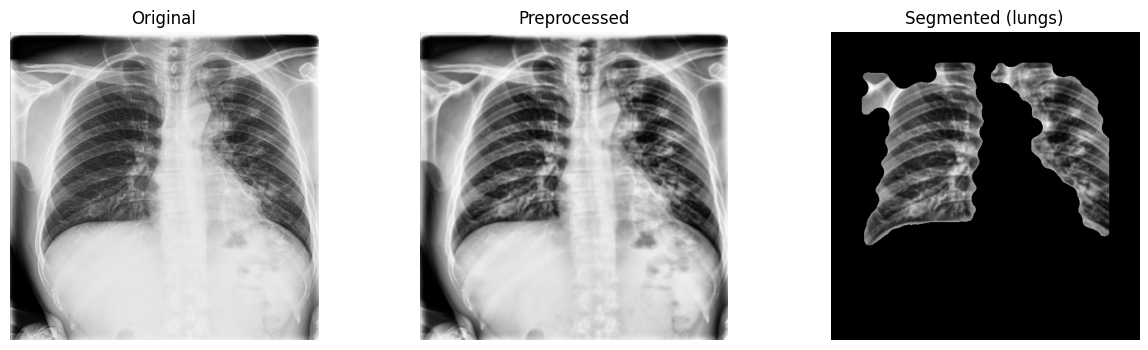

mask sum: 63075


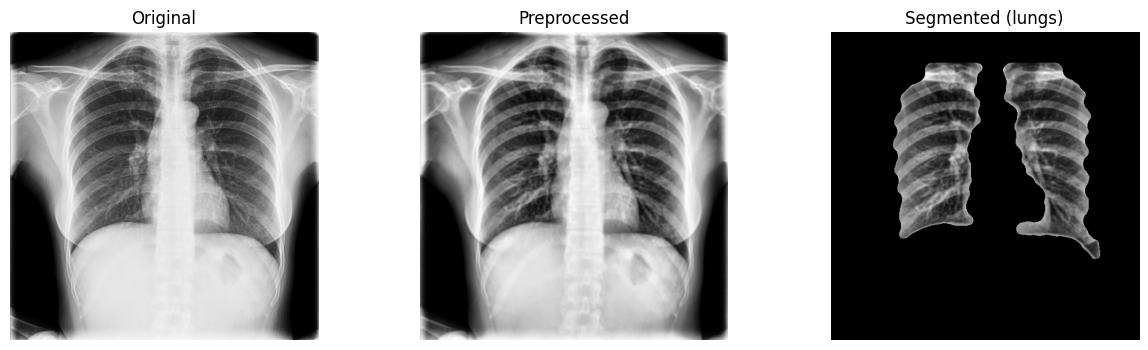

mask sum: 65507


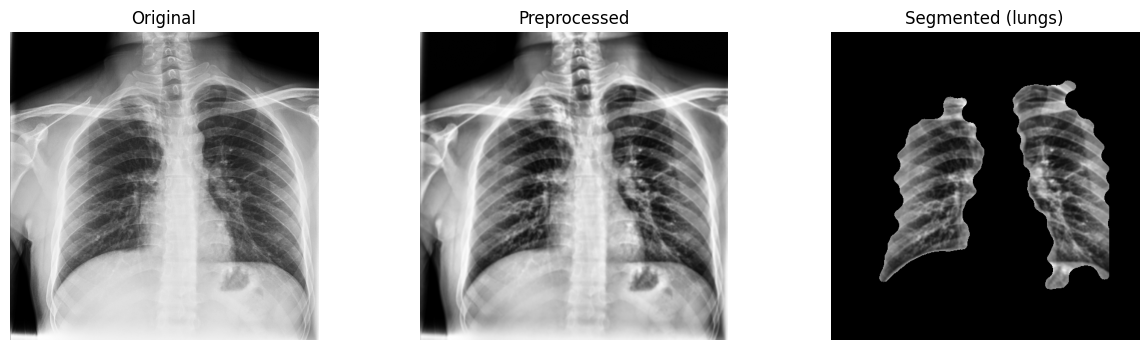

In [7]:
sample_img = cv2.imread(paths_balanced[0], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[1], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[2], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[3], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[4], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[5], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[6], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

sample_img = cv2.imread(paths_balanced[7], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()


sample_img = cv2.imread(paths_balanced[8], cv2.IMREAD_GRAYSCALE)

pre = preprocess_image(sample_img)
seg, mask = segment_lungs_final(pre)

print("mask sum:", mask.sum())

plt.figure(figsize=(15,4))
plt.subplot(1,3,1); plt.imshow(sample_img, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(pre, cmap="gray"); plt.title("Preprocessed"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(seg, cmap="gray"); plt.title("Segmented (lungs)"); plt.axis("off")
plt.show()

